In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
#import gsw

In [8]:
#state0 = xr.open_dataset('/Users/weiyangbao/Desktop/sill12/state_007.nc')
state0 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/sill30/state_004.nc')
t0 = 60 # Start from day 30
tn = len(state0.T) # End day
state = state0.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction

In [9]:
Qsg = 400 # subglacial discharge
x_sill = 28
xdist = state.X.data / 1000
depth = state.Z.data
#pres = gsw.p_from_z(depth, 0)
pt = state.Temp.data.mean(2).mean(0) # first y-average then t-average
s = state.S.data.mean(2).mean(0)
#rho = gsw.rho(s, pt, pres)

u0 = state.U.data # dims = T, Z, Y, Xp1
u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
u = u_ymean.mean(0)

In [10]:
# Find the uppler and lower layer depth above the sill crest
def Layer(u,sill_depth):
    # Layer interface, zero velocity crossing point
    l = np.argmax(u[:, x_sill] < 0)
    # Layer index of the sill depth
    ls = np.argwhere(u[:,x_sill] == 0)[0][0]
    # Calculate layer depth, h1:upper h2:lower
    if l <= 10:
        h1 = 0.5 * l       
    elif l <= 20:
        h1 = 5 + (l - 10)
    elif l <= 30:
        h1 = 15 + 1.5 * (l - 20)
    elif l <= 40:
        h1 = 30 + 4 * (l - 30)
    elif l <= 50:
        h1 = 70 + 8 * (l - 40)
    h2 = sill_depth - h1
    return (l, ls, h1, h2)

In [14]:
sill_depth = 30
l, ls, h1, h2 = Layer(u, sill_depth)
s1 = s[:l, :].mean(0)
s2 = s[l:ls, :].mean(0)
u1 = u[:l, :].mean(0)
u2 = u[l:ls, :].mean(0)

g = 8e-4 * 9.8 * (s2 - s1)  # Reduced gravity
with np.errstate(divide='ignore', invalid='ignore'):
    # Ignore divide by 0 warning
    Fr1 = (u1 ** 2) / (h1 * g)  # Froude number
    Fr2 = (u2 ** 2) / (h2 * g)
    G = Fr1 + Fr2 # Composite Froude number
    P = s2 / (s2 - s1)   # Mixing factor

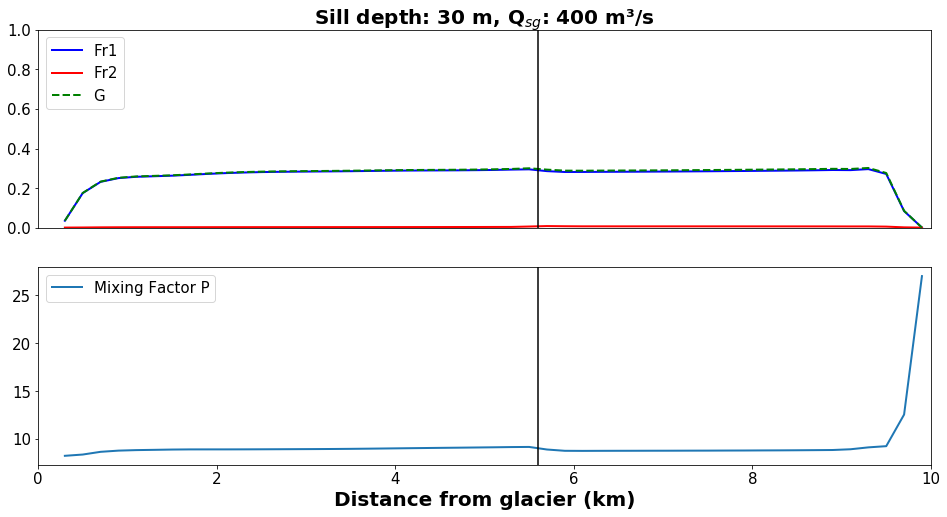

In [6]:
#fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Sill012/FrPseries/"
fig_path = "/home/1959/Jupyter_Figs/sill30/FrPseries/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
# Make plots
fig = plt.figure(figsize=(16,8))
#ax1.title('Sill depth = ' + str(sill_depth) + r' m, Q_s_g: ' + str(Qsg) + ' m\u00B3/s', size = 25, weight = 'bold')
# Plot Froude number
ax1 = fig.add_subplot(211)
plt.plot(xdist,Fr1,'b-',linewidth=2)
plt.plot(xdist,Fr2,'r-',linewidth=2)
plt.plot(xdist,G,'g--',linewidth=2)
ax1.axvline(x=5.6,color='k')
plt.legend(['Fr1','Fr2','G'], loc='upper left', fontsize=15)
ax1.set_xlim([0,10])
ax1.set_ylim([0,1])
ax1.tick_params(axis='y', labelsize=15)
plt.title("Sill depth: " + str(sill_depth) + ' m, Q$_{sg}$: ' + str(Qsg) + ' m\u00B3/s', size = 20, weight = 'bold')
ax1.axes.get_xaxis().set_visible(False)

# Plot mixing factor P
ax2 = fig.add_subplot(212)
plt.plot(xdist,P,linewidth=2, label='Mixing Factor P')
ax2.axvline(x=5.6,color='k')
ax2.legend(loc = 'upper left', fontsize = 15)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xlim([0,10])
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel('Distance from glacier (km)', size = 20, weight = 'bold')

fig.savefig(fig_path + '/Qsg' + str(Qsg) + '.png', dpi = 150, bbox_inches='tight')